In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.stats import multivariate_normal

In [3]:
#load the data
def load():
    df = pd.read_excel (r'Concrete_Data.xls')
    return df

In [4]:
def scale(df):
#scale the data to [0-1] range
    col=df.columns
    v = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    v_scaled = min_max_scaler.fit_transform(v)
    df = pd.DataFrame(v_scaled, columns=col)
    return df

In [49]:
def splits(df):
#randomly split the train and test datasets
    #kf =  RepeatedKFold(n_splits=5, n_repeats=1)
    kf =  RepeatedKFold(n_splits=10, n_repeats=1, random_state=12883823)
    df_train_l=[]
    df_test_l=[]
    for train, test in kf.split(df):
        df_train_l.append(train.reshape(-1,1))
        df_test_l.append(test.reshape(-1,1))
    return df_train_l,df_test_l


In [37]:
def getXandY(ind,df):
    #separate the data and the labels
    df=df.to_numpy()
    df=df[ind]
    Y=df[:,0,8].reshape(-1,1)
    X=df[:,0,0:8]
    return X,Y

In [28]:
def Kernal(X1,X2,T,m):
    return np.exp(- np.dot((X1-X2),(X1-X2).T)/m*T)
    

In [29]:
def getC(T,Betainv,n,m,X_train):
    C=np.zeros((n,n))
    for i in range(n) :
        for j in range(n):
            C[i,j]=(Kernal(X_train[i,:].reshape(1,-1),X_train[j,:].reshape(1,-1),T,m))
    C=C+Betainv*np.identity(n)
    return C

In [43]:
def getKstar(z,T,n,m,X_test,X_train):
    Kstar=np.zeros((n,1))
    for j in range(n):
        Kstar[j,:]=Kernal(X_test[z,:].reshape(1,-1),X_train[j,:].reshape(1,-1),T,m)
    return Kstar

In [44]:
def getScalerC(z,T,m,Betainv,X_test):
    ScalerC=Kernal(X_test[z,:].reshape(1,-1),X_test[z,:].reshape(1,-1),T,m)
    return ScalerC+Betainv

In [45]:
def calculateW(X_test,X_train,Y_train,Betainv=2,T=2):
    n=X_train.shape[0]
    m=X_train.shape[1]
    C=getC(T,Betainv,n,m,X_train)
    Ypredict=np.zeros((X_test.shape[0],1))
    mean=np.zeros((X_test.shape[0],1))
    Cov=np.zeros((X_test.shape[0],1))
    cinv=np.linalg.pinv(C)
    for i in range(X_test.shape[0]):
        Kstar=getKstar(i,T,n,m,X_test,X_train)
        ScalerC=getScalerC(i,T,m,Betainv,X_test)
        s1=np.dot((Kstar.T),cinv)
        mean[i]=np.dot(s1, Y_train)
        Cov[i]=ScalerC- np.dot(s1,Kstar)
        Ypredict[i,:]=np.random.normal(mean[i], math.sqrt(Cov[i]))
    return Ypredict,mean,Cov


In [69]:
#calculating the accuracy and the confudion matrix
def evaluation(Y_test,Y_pred):
    errorr=(1/(2*Y_test_pred.shape[0]))*np.sqrt(np.sum(np.multiply((Y_test- Y_pred),(Y_test- Y_pred))))
    return errorr

In [70]:
def plot_accuracy(train_acc_l,test_acc_l):
    x= [i for i in range(1,11)]
    plt.plot(x, train_acc_l , 'b^',linestyle='-',label='train error')
    plt.plot(test_acc_l , 'g+',linestyle='-',label='test_error')
    plt.xlabel('k folds')
    plt.ylabel('error')
    plt.legend()
    plt.show()

(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)
(927, 927)


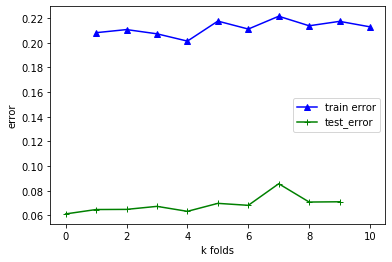

train_error [0.20821180191624183, 0.21072539810820023, 0.20729299382416222, 0.20138138240962075, 0.21759766059866797, 0.2111536760931801, 0.22154308296942055, 0.2138099863178265, 0.21739532484758284, 0.2129397135614465]
test_error [0.061248769430684656, 0.06480019373308958, 0.06492286028871783, 0.06737406060295713, 0.06334141211298079, 0.06981052171602806, 0.06821257430616151, 0.08572836655823748, 0.07087501046725007, 0.07109019944573301]
avg_error_train 0.0002289159677072653
avg_error_test 7.415361042738298e-05


In [71]:
#main

Betainv=2 #B
T=2 #gaussian kernal parameter
df=load()
df=scale(df)
df_train_l,df_test_l=splits(df)
train_acc_l=[]
test_acc_l=[]
for i in range (len(df_train_l)):
    df_train=df_train_l[i]
    df_test=df_test_l[i]
    X_train,Y_train=getXandY(df_train,df)
    X_test,Y_test=getXandY(df_test,df)
    Y_train_pred,mean,Cov=calculateW(X_train,X_train,Y_train,Betainv,T)
    Y_test_pred,mean,Cov=calculateW(X_test,X_train,Y_train,Betainv,T)
    train_acc=evaluation(Y_train,Y_train_pred)
    test_acc=evaluation(Y_test,Y_test_pred)
    train_acc_l.append(train_acc)
    test_acc_l.append(test_acc)
avg_acc_train=sum(train_acc_l)/10
avg_acc_test=sum(test_acc_l)/10

plot_accuracy(train_acc_l,test_acc_l)
print("train_error",train_acc_l)
print("test_error",test_acc_l)
print("avg_error_train",avg_acc_train/927)
print("avg_error_test",avg_acc_test/927)